## yt-dlp

In [10]:
!yt-dlp -o "../data/youtube/bluearchive/%(title)s.%(ext)s" https://www.youtube.com/watch?v=MeIr__26dAw

[youtube] Extracting URL: https://www.youtube.com/watch?v=MeIr__26dAw
[youtube] MeIr__26dAw: Downloading webpage
[youtube] MeIr__26dAw: Downloading ios player API JSON
[youtube] MeIr__26dAw: Downloading android player API JSON
[youtube] MeIr__26dAw: Downloading m3u8 information
[info] MeIr__26dAw: Downloading 1 format(s): 302+251
[download] ..\data\youtube\bluearchive\Let's Go!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!.webm has already been downloaded


## ffmpeg

In [11]:
!ffmpeg -i "../data/youtube/bluearchive/Let's Go!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!.webm" -vf "fps=1" "../data/raw/MeIr__26dAw/frame_%d.png"

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 17.0.6
  configuration: --prefix=/d/bld/ffmpeg_1705436951673/_h_env/Library --cc=clang.exe --cxx=clang++.exe --nm=llvm-nm --ar=llvm-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --ld=lld-link --target-os=win64 --enable-cross-compile --toolchain=msvc --host-cc=clang.exe --extra-libs=ucrt.lib --extra-libs=vcruntime.lib --extra-libs=oldnames.lib --strip=llvm-strip --disable-stripping --host-extralibs= --disable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libopus --pkg-config=/d/bld/ffmpeg_1705436951673/_build_env/Library/bin/pkg-config
  libavutil      58. 29.100 / 58. 29.100
  libavcodec     60. 31.102 / 6

## Caption

In [12]:
from PIL import Image
import requests
from transformers import AutoProcessor, AutoModel
import torch

model = AutoModel.from_pretrained("google/siglip-base-patch16-256-i18n")
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-256-i18n")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

texts = ["a photo of 2 cats", "a photo of 2 dogs"]
inputs = processor(text=texts, images=image, padding="max_length", return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

logits_per_image = outputs.logits_per_image
probs = torch.sigmoid(logits_per_image) # these are the probabilities
print(f"{probs[0][0]:.1%} that image 0 is '{texts[0]}'")


27.0% that image 0 is 'a photo of 2 cats'


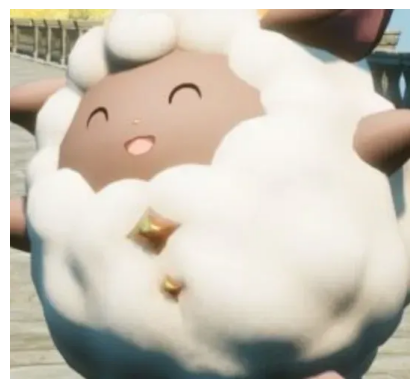

Text: a cat, Similarity: tensor([0.0169], device='cuda:0')
Text: a sheep, Similarity: tensor([0.0987], device='cuda:0')
Text: a sheep monstar, Similarity: tensor([0.1161], device='cuda:0')
Text: a laughing ball-shaped sheep monster with brown skin and white wool, Similarity: tensor([0.1703], device='cuda:0')


In [13]:
import matplotlib.pyplot as plt
import torch

from transformers import AutoProcessor, AutoModel
from PIL import Image

# Ensure the model and tensors are on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_path = "../data_examples/lamball_image.webp"
image = Image.open(image_path)

plt.imshow(image)
plt.axis('off')
plt.show()

model = AutoModel.from_pretrained("google/siglip-base-patch16-256-i18n").to(device)
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-256-i18n")

def word_processor(word):
    inputs = processor(text=word, return_tensors="pt", padding="max_length", truncation=True).to(device)
    with torch.no_grad():
        embedding = model.get_text_features(**inputs)
        embedding /= embedding.norm(dim=-1, keepdim=True)
    return embedding

def image_processor(image):
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        embedding = model.get_image_features(**inputs)
        embedding /= embedding.norm(dim=-1, keepdim=True)
    return embedding

def get_similarity(processed_text, processed_image):
    return torch.nn.functional.cosine_similarity(processed_text, processed_image, dim=-1)

processed_image = image_processor(image)
texts = [
    "a cat",
    "a sheep",
    "a sheep monstar",
    "a laughing ball-shaped sheep monster with brown skin and white wool"
]
for text in texts:
    processed_text = word_processor(text)
    print(f"Text: {text}, Similarity: {get_similarity(processed_text, processed_image)}")



## Crop

Red channel:
tensor([[0.0000],
        [0.9294]])
Green channel:
tensor([[0.0000],
        [0.1098]])
Blue channel:
tensor([[0.0000],
        [0.1412]])
Alpha channel:
tensor([[0.],
        [1.]])


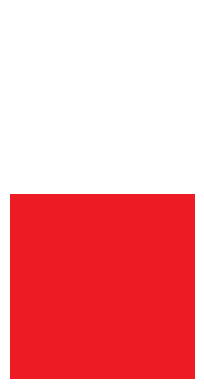

In [14]:
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms


def show_rgba(image_path):
    # See RGBA data
    image = Image.open(image_path)
    to_tensor = transforms.ToTensor()
    tensor = to_tensor(image)

    for i, color in enumerate(['Red', 'Green', 'Blue', 'Alpha']):
        print(f"{color} channel:")
        print(tensor[i])
    plt.imshow(tensor.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


show_rgba('../data_examples/transparent_indonesia_flag.png')
# Alpha channel: tensor([[0.], [1.]]). It means alpha 0 is transparent.
